<h1><center>Сегментация изображений</center></h1>

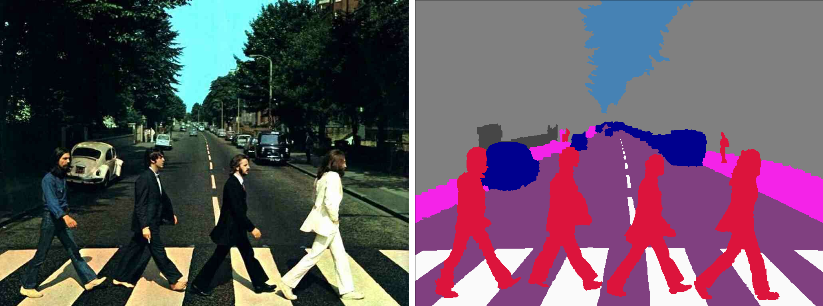

## План занятия:

* Что такое сегментации изображений
* Где данная технология применяется
* Некоторые архитектуры нейронных сетей
* Архитектура U-net
* Подготовка датасета
* Обучение модели
* Тестирование


<h1><center>Теория</center></h1>

На данный момент мы находимся в ситуации, когда глубокое обучение оказывается очень успешным при работе с изображениями как данными, и в настоящее время получается так, что оно во многих случаях работает даже лучше, чем люди. Наиболее важные проблемы, которыми люди интересовались в решении задач компьютерного зрения - классификация изображений, детекция объектов и сегментация в порядке увеличения сложности. 
В результате решения задачи классификации мы хотим получить все классы объектов на изображении. В детектировании объектов мы идем на шаг дальше и работаем над локализацией объекта на изображении. В сегментации решается задача нахождения точной границы объекта на изображении.

## Что такое сегментация

Сегментация - это процесс, благодаря которому каждый пиксель изображения относится в определенный класс (попиксельная классификация). Существует два вида сегментаций: семантическая и инстанс-сегментация.
Семантическая сегментация изображения означает присвоение каждому пикселю определенной метки. В этом заключается главное отличие от классификации, где всему изображению ставится в соответствие только одна метка. Сегментация работает со множеством объектов одного класса как с единым целым.
Инстанс-сегментация делает тоже самое, но дополнительно обрабатывает каждый отдельный найденный объект одного класса как различные объекты. Решение задачи инстанс-сегментации сложнее, чем семантическая сегментация.


## Применение алгоритмов сегментации в реальной жизни

1) Распознавание рукописного текста:

В [работе](https://arxiv.org/pdf/1906.05229.pdf) 2019 года показано как с помощью U-net находятся линии и текст от руки.
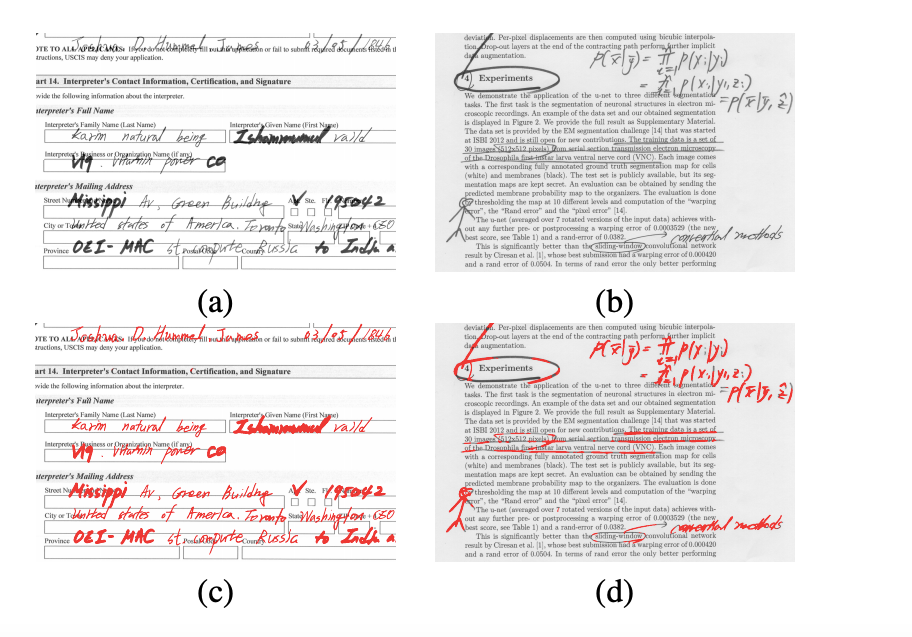

2) Сегментация медицинских изображений

Первое упоминание архитектуры, которую мы сегодня будем разбирать было сделано в этой [статье](https://arxiv.org/abs/1505.04597). И касалось оно сегментации медицинских изображений. С помощью этих методов можно анализировать например состояние внутренних органов: проверять их целостность и объем (трехмерная семантическая сегментация), находить опухоли.
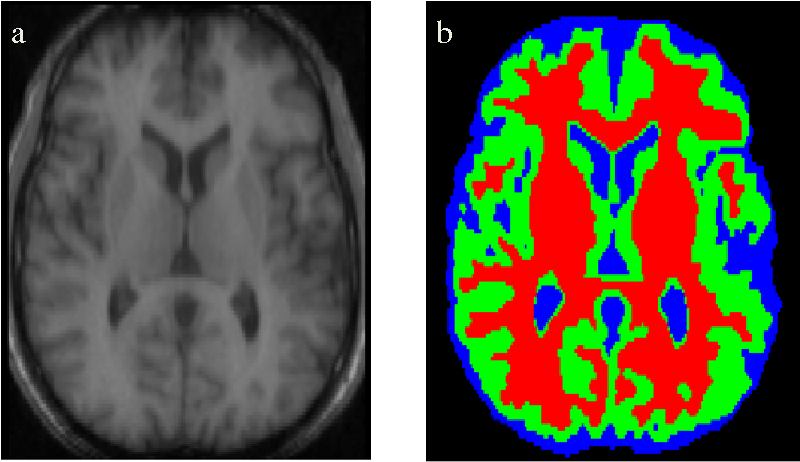

3) Режим portrait mode 

В этом режиме на смартфонах можно отделить передний план от фона. И, например, заблюрить фон, сфокусировав внимание на персоне в кадре.
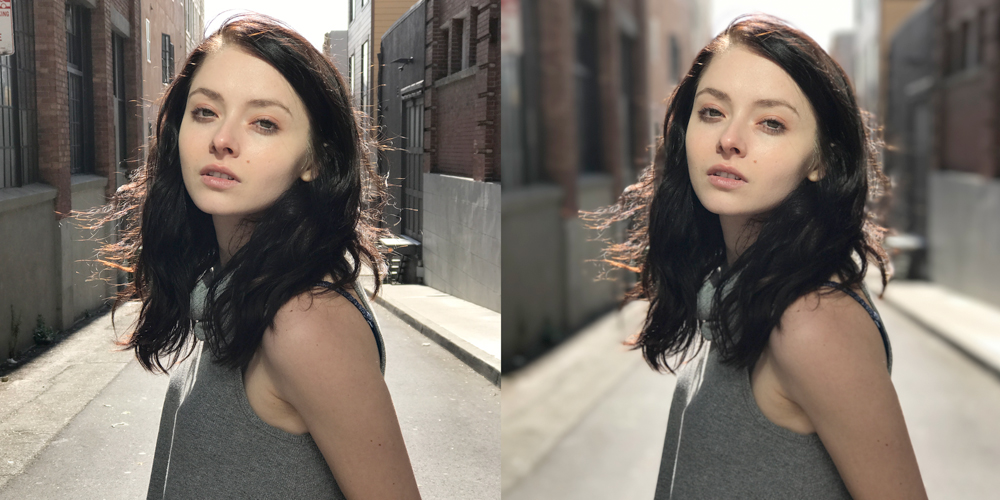


4) Индустрия моды

Используется для извлечения с кадра элементов одежды. Таким образом пользователь может примерять разную одежду онлайн.
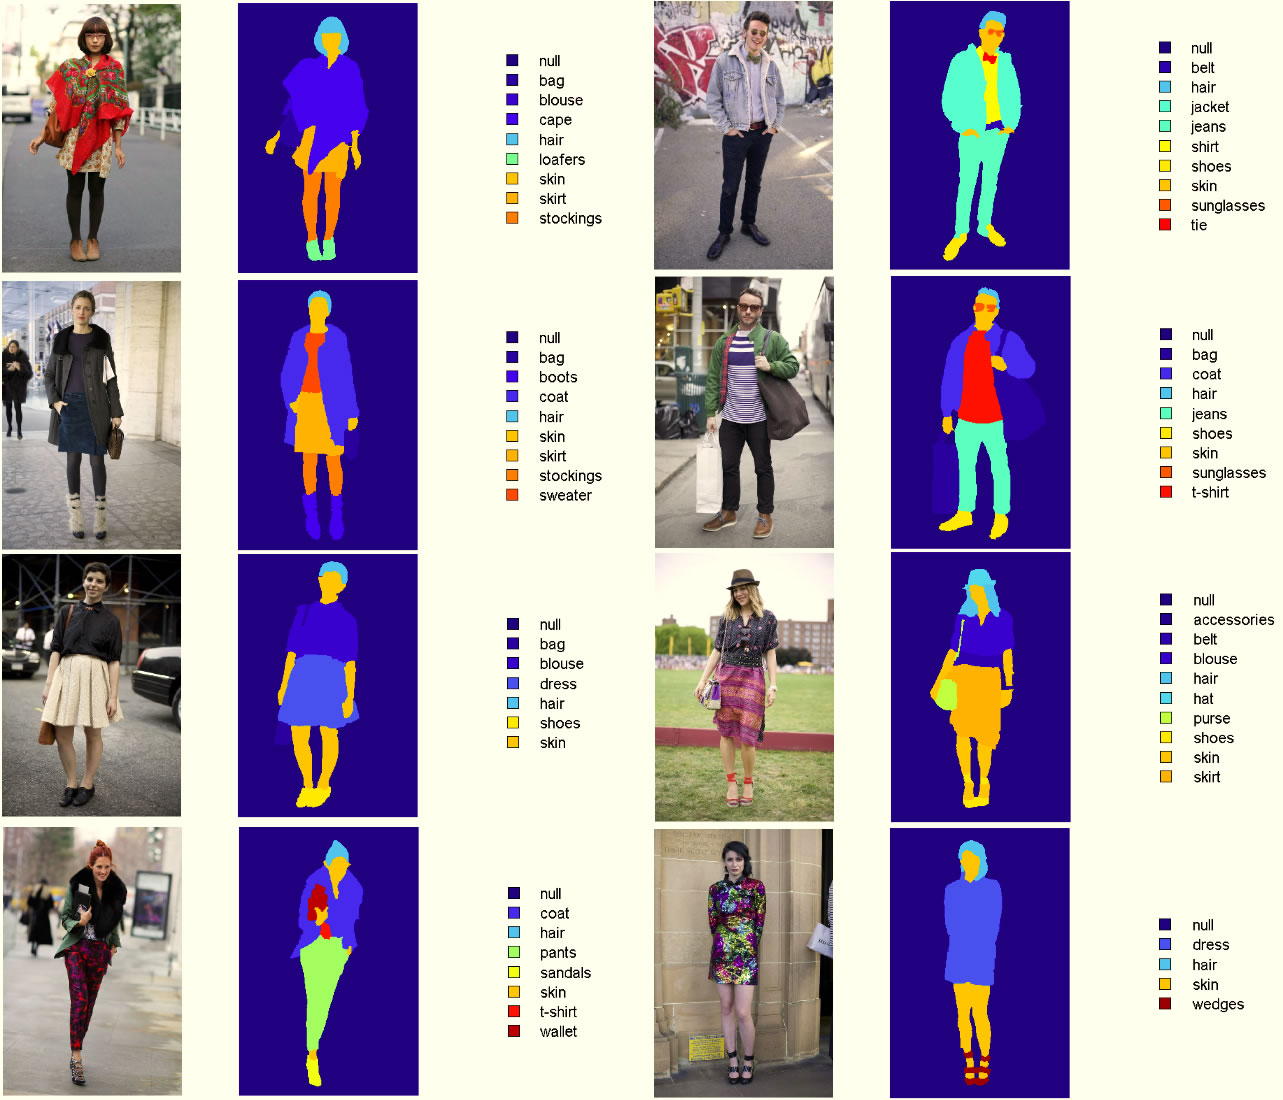

5) Автономное вождение

Здесь алгоритмы сегментации используются для обнаружения транспортных средств, пешеходов и других предметов, представляющих интерес. Затем результат сегментации используется для принятия решений по оптимальному управлению автопилотируемым транспортным средством. Как раз в таких системах очень важно понимать границы объектов.
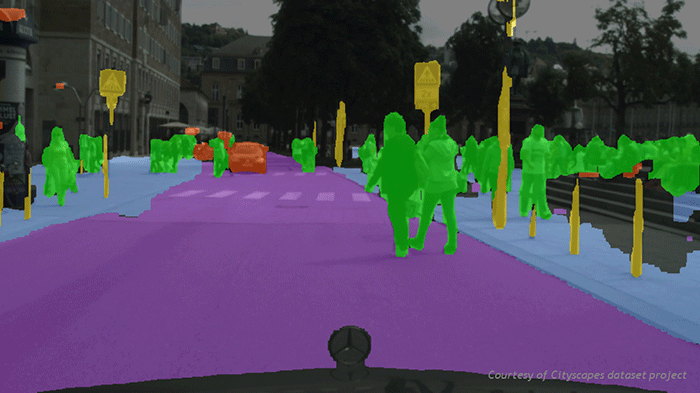

## Краткий обзор методов сегментации

Методы глубокого обучения позволяют добиваться хороших результатов в задаче семантической сегментации изображений. Здесь мы вкратце обсудим популярные архитектуры моделей и функции потерь, которые применяются для обучения.

## Fully Convolutional Network

Одна из самых простых архитектур - это FCN (Fully Convolutional Network). Это первая удачная попытка использования нейронной сети для задачи семантической сегментации. В этой архитектуре все слои сверточные. Получают сегментацию того же разрешения, что и на входе.
Одна из основных проблем - это низкое разрешение на выходе.
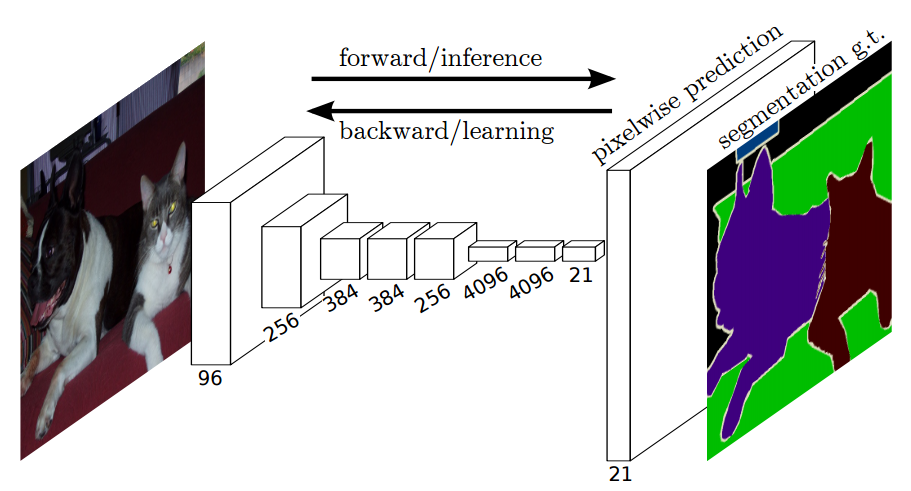

## Unet

Когда мы изучаем задачу сегментацию, Unet - это одна из базовых и наиболее используемых моделей для сегментации. Есть очень много имплементаций Unet, но давайте разберемся с оригинальной Unet.
Ее архитектура представлена на картинке ниже.
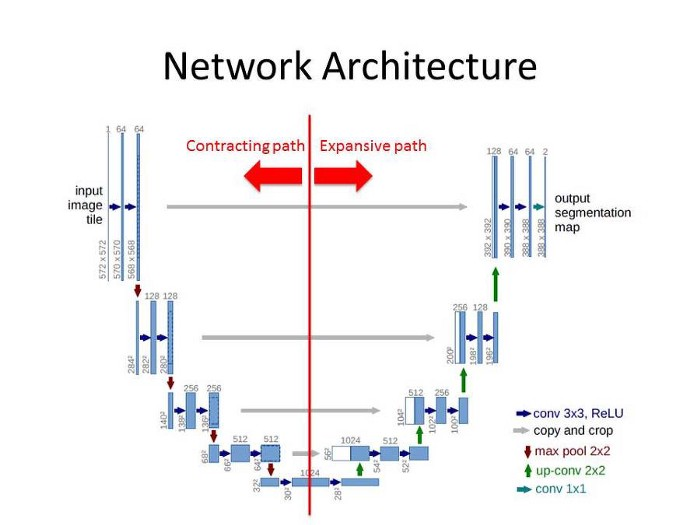

Архитектура unet может быть разделена на левую (уменьшающую размерность картинки) и правую (увеличивающую) части. 
Левая часть - это сверточная сеть. Два 3х3 сверточных слоя следуют за активационной функцией Relu последовательно(Sequentially) и после этого применяется 2x2 maxpool слой (на картинке красная стрелка).
В это время правая часть - то место где происходят действительно интересные вещи. Правая часть также имеет два 3х3 сверточных слоя, соединенные вместе (Sequentially), но нет привычных нам Relu активационной функции и MaxPool слоя. Вместо них - 2х2 транспонированный сверточный слой или деконволюционный (зеленая стрелка на изображении). Проходя по расширяющему пути, мы будем брать изображение (копию) из левой части и комбинировать с изображением из правой (серая стрелка на изображении). Помните, что последовательные 3х3 сверточные слои также используются в правой части. Поэтому вход для них будет комбинацией с изображения из левой части и прошлого слоя (комбинация половин белой и голубой коробки в левой части изображения). Итог работы нейронной сети - это выходная сегментационная карта.


<h1><center>Практическая часть</center></h1>

Что ж, перейдем от теории к практике. Давайте закодим нашу сетку.

## Часть 1. Создание модели

Как мы отметили ранее, в архитектуре присутствует 3х3 двойной сверточный слой следующий за активационной функцией Relu в обеих частях сетки.


Шаг 1.

Создадим функцию dual_conv(), параметры которой входные и выходные параметры каналов. Внутри функции последовательные сверточные слои с ядром 3 (3х3) каждый предшествует Relu активационной функции и для лучшей сходимости слои BatchNorm2d:

In [1]:
import torch
import torch.nn as nn

def dual_conv(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        #nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU()
        #nn.BatchNorm2d(num_features=out_channels)
    )
    return conv

Шаг 2.

Создадим класс Unet() и сделаем слои левой части и maxpool слой. В каждом слое мы используем dual_conv(). Давайте назовем  слой dwn_conv (5 слоев в левой части): 

Сделаем внутри класса функцию forward(), которой мы отправим входное изображение в левую часть:

Вот, отлично. Мы создали левую часть нейронной сети. Осталось сделать правую часть.

Шаг 4.

Теперь давайте задекларируем 4 слоя правой части и последнюю 1х1 conv в нашей функции __init__() класса. Вместо maxpool функции мы будем использовать 2х2 transpose convolution:

Шаг 5.

Как мы видим, в архитектуре входное изображение в правой части - это комбинация изображения с левой части
и с предыдущего слоя. Но для комбинации изображений они должны быть одинаковых размеров. Поэтому давайте создадим функцию crop_tensor() для вырезания этих изображений. Внутри этой функции мы подразумеваем, что наши изображения - это тензоры.

Что происходит в функции crop_tensor() ?

tensor = изображение с левой части, которое необходимо обрезать
target tensor = изображение в правой части, которое сопоставляется с вырезанным левым изображением

Возьмем последний размер обоих тензоров target_size и tensor_size, т.к. их высота и ширина одинаковы. 
Например: x=torch.Size([1,512,64,64]), таким образом x[2] = 64

Теперь мы имея размеры обоих изображений, вычтем размер меньшего тензора из большего. Предположим
target_size = 56 и tensor_size = 64 -> delta(разница между размерами) будет 8.

Но мы ведь будем вырезать изображение из всех углов 'height' * 'width', поэтому мы разделим delta на 2. 
Таким образом, height и width могут быть вырезаны равно:
    8 => h*w=4*4

теперь вернем вырезанный тензор
[:,:,] = все измерения
[delta:tensor_size-delta, delta:tensor_size-delta] = вырезанное изображение

[4:64-4, 4:64-4] => 4:60, 4:60 
в примере выше нам необходима картинка 56х56

На картинке ниже показан пример вырезанной высоты:

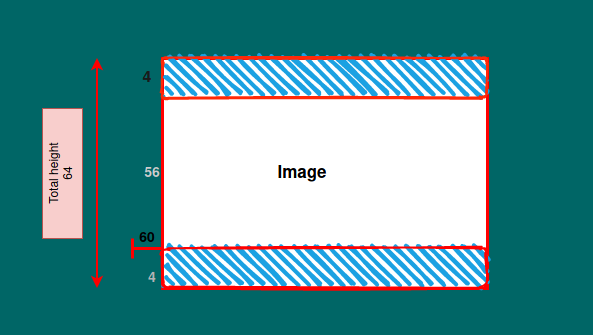

In [2]:
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    
    return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

Шаг 6.

Теперь допишем наш forward правой части.

Сначала Транспонированный слой x берет входное x9 последнего слоя левой стороны. 
Теперь комбинируем изображение x и изображение из слоя во входной части.
Но т.к. размеры изображений разные, мы применяем crop_tensor().

print(x7.size()) : torch.Size([1,512,64,64])
print(x.size())  : torch.Size([1,512,56,64])

Комбинируем оба изображения используя torch.cat() и подставляем в up_conv():

В итоге наш класс Unet выглядит следующим образом:

In [1]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.contracting_11(X) # [-1, 64, 256, 256]
        x2 = self.contracting_12(x1) # [-1, 64, 128, 128]
        x3 = self.contracting_21(x2) # [-1, 128, 128, 128]
        x4 = self.contracting_22(x3) # [-1, 128, 64, 64]
        x5 = self.contracting_31(x4) # [-1, 256, 64, 64]
        x6 = self.contracting_32(x5) # [-1, 256, 32, 32]
        x7 = self.contracting_41(x6) # [-1, 512, 32, 32]
        x8 = self.contracting_42(x7) # [-1, 512, 16, 16]
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.expansive_11(x) # [-1, 512, 32, 32]
        x = self.expansive_12(torch.cat((x, x7), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        x = self.expansive_21(x) # [-1, 256, 64, 64]
        x = self.expansive_22(torch.cat((x, x5), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        x = self.expansive_31(x) # [-1, 128, 128, 128]
        x = self.expansive_32(torch.cat((x, x3), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        x = self.expansive_41(x) # [-1, 64, 256, 256]
        x = self.expansive_42(torch.cat((x, x1), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

## Часть 2. Подготовка датасета

В обучении нашей модели мы будем использовать датасет для автопилотируемых машин.
Скачать весь датасет (~3 Гб) можно по этой ссылке: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge

После скачивания создаем внутри проекта папку 'Semantic segmentation for Self-driving Cars' и разорхивируем туда все содержимое архива. 

Шаг 1.

Начнем с того, что посмотрим на наш датасет. Внутри куча схожих по названию папок, каждая из которых содержит картинки. 
Но мы можем выделить в этом датасете два вида картинок. 
1) Это обычные цветные картинки.
Например dataA/dataA/CameraRGB/02_00_000.png
2) И есть связанные с ними картинки, разбитые на области с одинаковыми яркостями пикселей.
Например dataA/dataA/CameraSeg/02_00_000.png, в ней все тоже самое, что и в первой, но  она просегментирована.

И еще заметим, что нигде в датасете нет явной информации о классах. Мы должны дать им имена сами.

Начнем писать код

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

Найдем уникальные значения пискселей на картинке, и каждое такое значение будет соответсвовать целому классу.

In [3]:
np.unique(plt.imread('Semantic segmentation for Self-driving Cars/dataA/dataA/CameraSeg/02_00_000.png')[:,:,0]*255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

В итоге видим, что у нас 13 классов. Вы можете самостоятельно поотображать семантическую маску 
для каждого класса используя код ниже:

Но а я лишь скажу что наши классы называются следующим образом и идут в таком порядке:

In [4]:
labels = ['Unlabeled','Building','Fence','Other',
                'Pedestrian', 'Pole', 'Roadline', 'Road',
                'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']

Шаг 2.

Теперь приведем наш датасет к удобному виду, для этого сначала разделим все на два списка с rgb картинками и seg.

In [5]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('Semantic segmentation for Self-driving Cars'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

Теперь завернем эти два списка в DataFrame из библиотеки pandas.
В итоге выведем первые пять записей из получившегося датафрейма:

In [6]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
df.sort_values(by='cameraRGB',inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.head(5))

                                           cameraRGB  \
0  Semantic segmentation for Self-driving Cars/da...   
1  Semantic segmentation for Self-driving Cars/da...   
2  Semantic segmentation for Self-driving Cars/da...   
3  Semantic segmentation for Self-driving Cars/da...   
4  Semantic segmentation for Self-driving Cars/da...   

                                           cameraSeg  
0  Semantic segmentation for Self-driving Cars/da...  
1  Semantic segmentation for Self-driving Cars/da...  
2  Semantic segmentation for Self-driving Cars/da...  
3  Semantic segmentation for Self-driving Cars/da...  
4  Semantic segmentation for Self-driving Cars/da...  


Шаг 3. 

Теперь обернем все в кастомный датасет для удобной работы в пайторч.

In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

Создадим класс для кастомного датасета:

In [8]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        lab = np.asarray(plt.imread(self.label_arr[index])).astype('float')[:,:,0]*255
        lab = torch.as_tensor(lab).unsqueeze(0)
        lab = lab.unsqueeze(0)
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

Затем разделим наш датасет на тренировочную и тестовую выборки.
И обернем их в наш кастомный класс.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df,test_size=0.3)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)


train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

И теперь уже обернем то, что получилось в известные нам в pytorch даталоадеры

In [10]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [32]:
data = next(iter(train_data_loader))
print(data[0].mean(), data[0].std())

tensor(0.4141) tensor(0.2477)


In [11]:
learning_rate = 0.0001
epochs = 50

## Часть 3. Обучение

Для обучения модели мы создадим тренировочную функцию, которая в качестве параметров будет получать 
модель, тренировочную дату, функцию потерь, оптимизатор, accuracy функцию и количество эпох.

Для функции потерь мы будем использовать функцию Dise Loss

In [12]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

Выберем утройство,на котором будем обучать нашу модель.

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda', index=0)

Определим нашу модель Unet

In [15]:
model = UNet(num_classes=13).to(device)

В качетсве оптимизатора возьмем Adam, описанный в оригинальной статье. 

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# The training loop
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

50 epochs, 7000 total_steps per epoch


определим оставшиеся параметры для нашего обучения

In [18]:
step_losses = []
epoch_losses = []

И сам процесс обучения

In [19]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
  
        # zero the parameter gradients
        optimizer.zero_grad()
      
      
        outputs = model(inputs[0])
  
        loss = dice_loss(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()
  
        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')

Epoch: 0, batchcount: 4999, avg. loss for last 5000 images: nan
Epoch 1, loss:  nan  time = 596.7455942630768 sec
Epoch: 1, batchcount: 4999, avg. loss for last 5000 images: nan
Epoch 2, loss:  nan  time = 594.4493200778961 sec
Epoch: 2, batchcount: 4999, avg. loss for last 5000 images: nan
Epoch 3, loss:  nan  time = 593.0994975566864 sec
Epoch: 3, batchcount: 4999, avg. loss for last 5000 images: nan
Epoch 4, loss:  nan  time = 592.9300725460052 sec
Epoch: 4, batchcount: 4999, avg. loss for last 5000 images: nan
Epoch 5, loss:  nan  time = 594.1897509098053 sec


Сохраним нашу модель:

In [40]:
PATH = './selfcarmodel.pth'
torch.save(model.state_dict(), PATH)

In [41]:
net=UNet(13)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Протестируем на первых 5 изображениях из тестового набора и посмотрим что вышло:

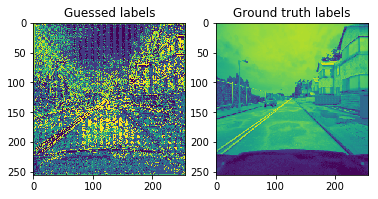

<Figure size 432x288 with 0 Axes>

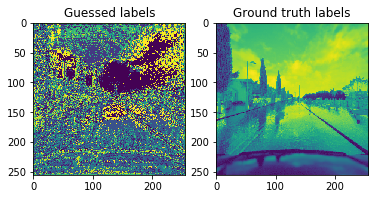

<Figure size 432x288 with 0 Axes>

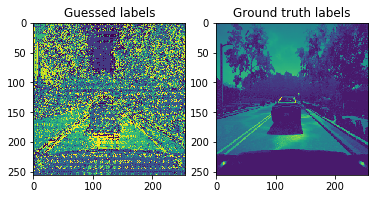

<Figure size 432x288 with 0 Axes>

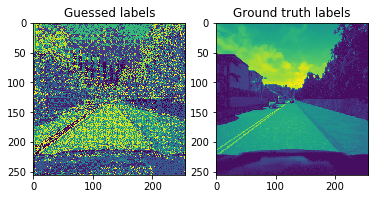

<Figure size 432x288 with 0 Axes>

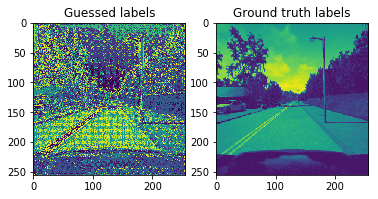

<Figure size 432x288 with 0 Axes>

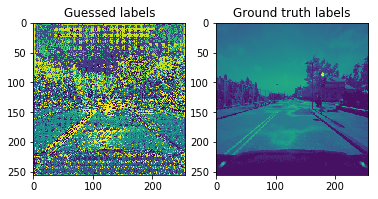

<Figure size 432x288 with 0 Axes>

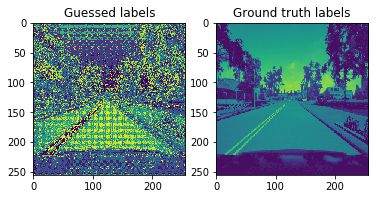

<Figure size 432x288 with 0 Axes>

In [46]:
NET=UNet(13)
NET.load_state_dict(torch.load('./selfcarmodel2.pth'))
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = NET(images[0])
    f, axarr = plt.subplots(1,2)
    axarr[0]. imshow(torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy())
    axarr[0].set_title('Guessed labels')

    axarr[1].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

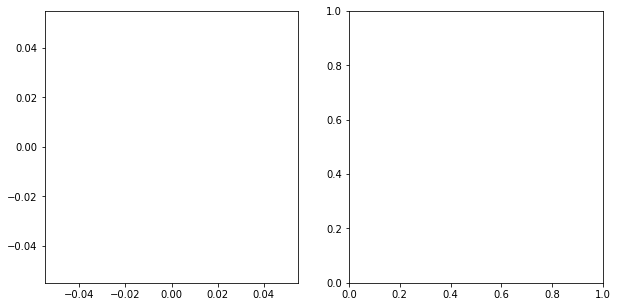

In [47]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(epoch_loss)

Cсылки:
1.
2.
3.
4.
5.
6.

Стоит сказать что уже есть реализация Unet в пайторч. Она и другие модели для решения задачи сегментации находятся в библиотеке segmentation_models_pytorch 

Если у вас ее нет, то для дальнейшей работы вам надо ее установить через pip

In [2]:
import torch

In [4]:
torch.cuda.is_available()

False

In [5]:
torch.cuda.device_count()

0

In [48]:
import segmentation_models_pytorch as smp

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', classes=13, activation='softmax').to(device)

step_losses = []
epoch_losses = []

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()


        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = dice_loss(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()
  
        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')

/home/user/anaconda3/envs/yolov3/lib/python3.6/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch: 0, batchcount: 4999, avg. loss for last 5000 images: 0.8707850225090981
Epoch 1, loss:  0.870948797081198  time = 457.7659742832184 sec
Epoch: 1, batchcount: 4999, avg. loss for last 5000 images: 0.8707313163161278
Epoch 2, loss:  0.870948797081198  time = 457.4067313671112 sec
Epoch: 2, batchcount: 4999, avg. loss for last 5000 images: 0.8707386296629905
Epoch 3, loss:  0.870948797081198  time = 456.50663328170776 sec
Epoch: 3, batchcount: 4999, avg. loss for last 5000 images: 0.8707932709336281
Epoch 4, loss:  0.870948797081198  time = 456.81090474128723 sec
Epoch: 4, batchcount: 4999, avg. loss for last 5000 images: 0.8707774653553962
Epoch 5, loss:  0.870948797081198  time = 456.6461179256439 sec
Epoch: 5, batchcount: 4999, avg. loss for last 5000 images: 0.8707608550310135
Epoch 6, loss:  0.870948797081198  time = 456.1035521030426 sec
Epoch: 6, batchcount: 4999, avg. loss for last 5000 images: 0.8707678854346276
Epoch 7, loss:  0.870948797081198  time = 456.05202770233154 